![title_pic](./img/title_page.png)
#### TV & Movie recommendation system using a collaborative and content based filtering approach

# Project Overview
The main goal for this project is to Develop a hybrid movie/TV recommendation system that combines collaborative filtering and content-based filtering to suggest new content to users. Currently, these techniques are applied independently. Our project aims to harness their combined potential.

**Collaborative Filtering**: Analyzes existing user profiles to discover shared preferences and recommend new content based on similarities.

**Content-Based Filtering**: Suggests new content with similar fearures to the movie/TV show that you input.


# Business Understanding
As streaming platforms pile-up content, users struggle to pinpoint films or shows that align with their tastes. The dubious presence of bias in platform algorithms exacerbates this challenge, making it harder for users to rely on platform recommendations. Biases emerge from factors like skewed user preferences, popularity bias, or even the platform's promotional agenda. As a result, recommended content may not cater to users' unique tastes, negatively affecting the overall user experience.

Streaming platforms stand to gain from implementing an unbiased hybrid recommendation system that blends content-based and collaborative filtering techniques. This approach leverages the best of both methods, increasing reliability and personalization while mitigating biases. The content-based technique analyzes features like genre and content description, while collaborative filtering harnesses the collective trends of user ratings. Together, they forge a powerful recommendation engine, enhancing user satisfaction and overall experience.


# Content Based Filtering
The content-based filtering recommendation system utilizes a cleaned dataset with 67,935 movies and TV shows, spanning 24 genres with accurate summaries. The following steps outline its creation:


- Preprocessed 'description' using techniques such as removing stopwords, employing regexTokenizer, and applying WordNetLemmatizer from the NLTK module.
- Used a custom WordNet function, curtosy of The Flatiron School,d to translate NLTK POS tags to WordNet tags.
- Visually analyzed a frequency plot across all genre targets, created in the last project I collaborated on, [github found here.](https://github.com/ParkedHampster/Twitter-Brand-Perception) , to pinpoint & remove common words among genres, thus boosting the impact of extracted features via TfidfVectorizer.
- With the improved preprocessed 'description', TfidfVectorizer from scikit-learn extracted 460 common words across genres.
- One-hot encoded 'genre' column, resulting in 24 distinct genres as features. In total, 484 features were obtained, considering genres and frequent words. Restricted features to under 500 for better efficiency, reduced overfitting, and simpler model evaluation.

In [1]:
import pandas as pd
import numpy as np
import random
import re


from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from wordcloud import WordCloud

from code.viz import word_plot

sns.set()


import warnings
warnings.filterwarnings('ignore')

In [2]:
# # increasing display to view large descriptions and reviewText
# pd.set_option('display.max_colwidth', None)

In [70]:
content_based = pd.read_csv('./data/descript_cont_based.csv')
content_based.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96834 entries, 0 to 96833
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        96834 non-null  object
 1   description  96833 non-null  object
 2   title        96834 non-null  object
 3   starring     96834 non-null  object
 4   movie_id     96834 non-null  object
dtypes: object(5)
memory usage: 3.7+ MB


### Removing descriptions with a total length less than 225 in order filter to more useful/useable language used.

In [71]:
content_based = content_based[(content_based['description'].str.len() >= 225)]
content_based.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79552 entries, 2 to 96833
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        79552 non-null  object
 1   description  79552 non-null  object
 2   title        79552 non-null  object
 3   starring     79552 non-null  object
 4   movie_id     79552 non-null  object
dtypes: object(5)
memory usage: 3.6+ MB


In [72]:
# copying dataframe to use meta data for evaluating similarity function later
movie_df = content_based.copy()
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79552 entries, 2 to 96833
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        79552 non-null  object
 1   description  79552 non-null  object
 2   title        79552 non-null  object
 3   starring     79552 non-null  object
 4   movie_id     79552 non-null  object
dtypes: object(5)
memory usage: 3.6+ MB


### Dropping columns that will not be used for Content filtering algorithm.

In [7]:
content_based.drop(columns=['title', 'starring'], inplace=True)

# Extracting features from description using NLP
- In order to use description as a feature in our content model I need to extract the top most frequent words used across description while removing any unecessary filler or generic language used for film synopsis.
- Using NLTK's NLP packages in order to extract and filter the top features

### Setting up a pos_tag template used when lemmatizing in order to narrow down the amount of root words created from lemmatization.

In [8]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags

    Provided by Flatiron School
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


### Instantiating NLTK classes to be used for preprocessing:

In [ ]:
# Set of English stopwords
sw = set(stopwords.words('english'))
# Regular expression tokenizer configuration
tokenizer = RegexpTokenizer('\w+')
# WordNet lemmatizer instance
lemmer = WordNetLemmatizer()
# Regular expression template for filtering
regex_template = r"[^\w\s]"

# Function to preprocess and lemmatize text
def preprocess_and_lemmatize(text):
    # Convert text to string
    text = str(text)
    # Remove special characters
    text = re.sub(regex_template, '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    words = tokenizer.tokenize(text)
    # Remove stopwords from words
    words = [word for word in words if word not in sw]
    # Lemmatize words based on wordnet tags
    lemmatized_words = [lemmer.lemmatize(word, pos=get_wordnet_pos(tag))
                        for word, tag in pos_tag(words)]
    # Return the lemmatized words joined as a single string
    return ' '.join(lemmatized_words)

# Function to tokenize and remove stopwords from text
def tokenize_sw(text):
    # Tokenize text
    words = tokenizer.tokenize(text)
    # Remove stopwords from words
    words = [word for word in words if word not in sw]
    # Return the words joined as a single string
    return ' '.join(words)

In [9]:
# Set of English stopwords
sw = set(stopwords.words('english'))

# Regular expression tokenizer configuration
tokenizer = RegexpTokenizer('\w+')

# WordNet lemmatizer instance
lemmer = WordNetLemmatizer()

# Regular expression template for filtering
regex_template = r"[^\w\s]"

In [10]:
# Function to apply NLTK for preprocess and lemmatization
def preprocess_and_lemmatize(text):
    # Convert text to string
    text = str(text)
    # Remove special characters
    text = re.sub(regex_template, '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    words = tokenizer.tokenize(text)
    # Remove stopwords from words
    words = [word for word in words if word not in sw]
    # Lemmatize words based on wordnet tags
    lemmatized_words = [lemmer.lemmatize(word, pos=get_wordnet_pos(tag))
                        for word, tag in pos_tag(words)]
    # Return the lemmatized words joined as a single string
    return ' '.join(lemmatized_words)

In [11]:
# Simpler function to just tokenize and remove stopwords from text 
def tokenize_sw(text):
    # Tokenize text
    words = tokenizer.tokenize(text)
    # Remove stopwords from words
    words = [word for word in words if word not in sw]
    # Return the words joined as a single string
    return ' '.join(words)

In [12]:
content_based['description'] = content_based['description'].apply(preprocess_and_lemmatize)
content_based.head()

genre                                        description   
2   Faith & Spirituality  angel show dumitru california la vegas new yor...  \
3            Documentary  documentary film life st faustina run whole wo...   
8            Documentary  documentary take journeyfrom christopher colum...   
10         Kids & Family  18 music video kid ear hang low wise man fooli...   
11  Faith & Spirituality  bible verse fun learn easy remember delightful...   

      movie_id  
2   0001421409  
3   0001485423  
8   0005092663  
10  0005123909  
11  0005419263

## Setting up wordplot to visualize top frequent words across 'description'

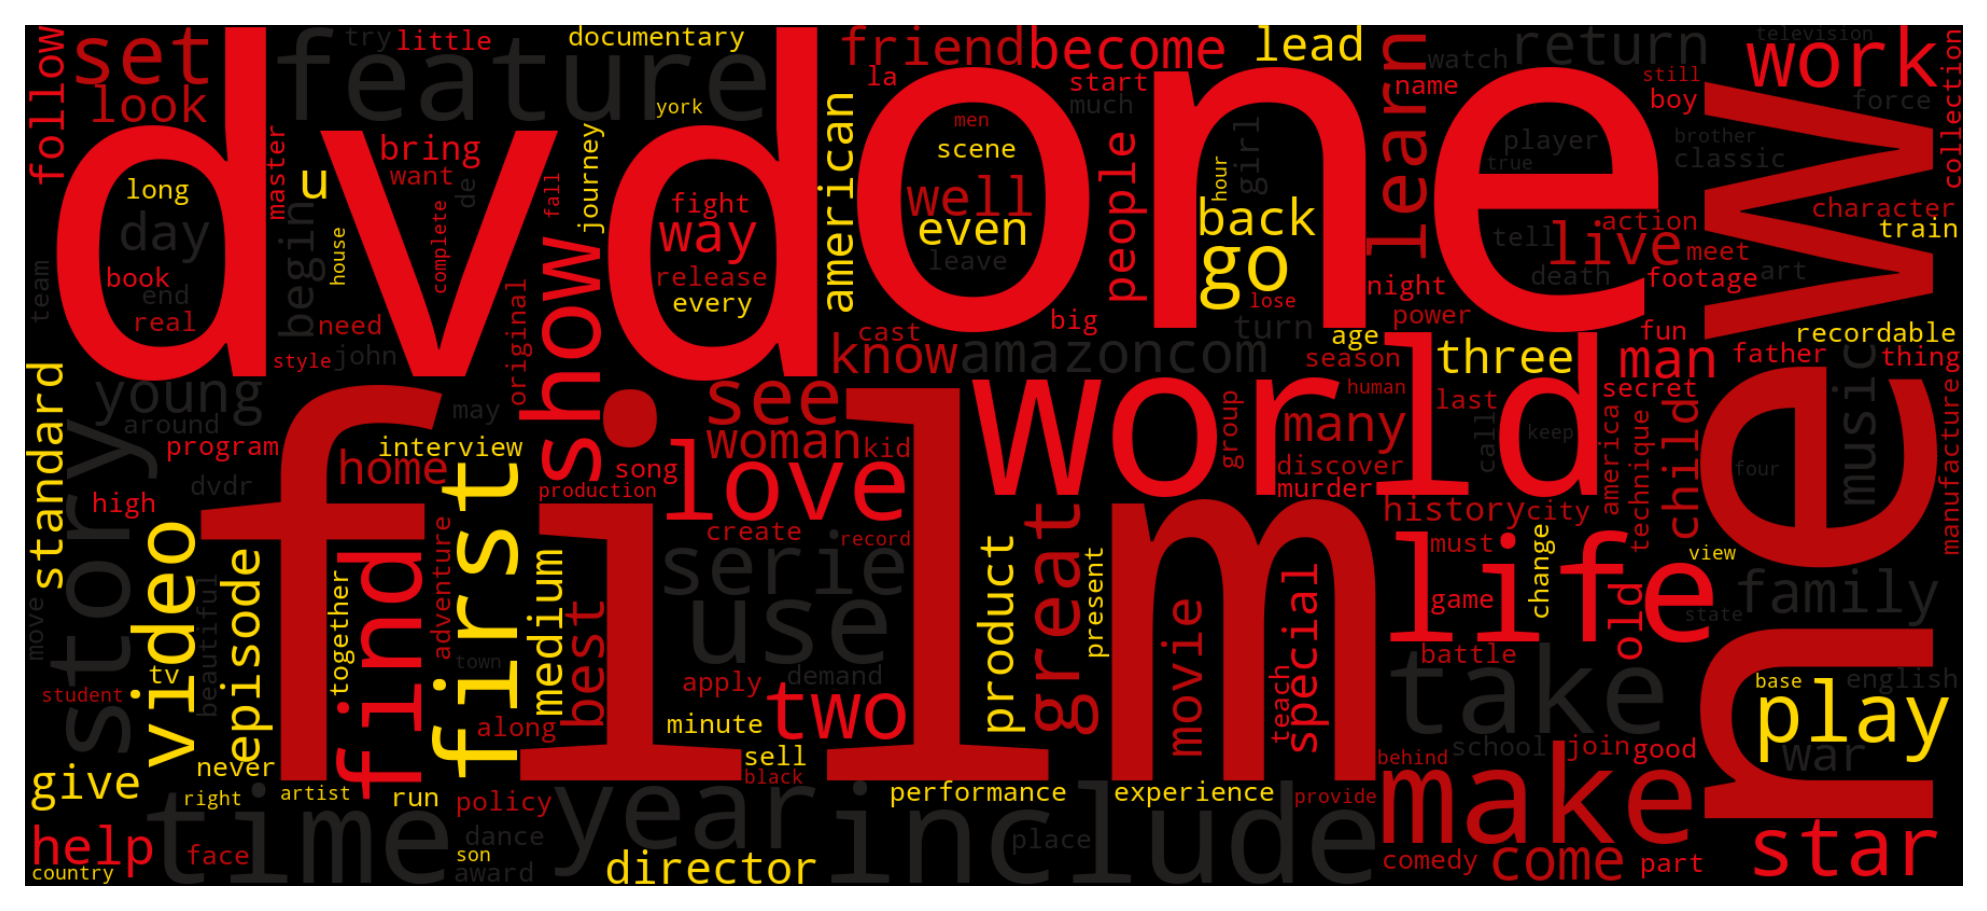

In [13]:
# This is the palette used in our associated
# presentation, available at a link later on
flix_colors = [
    "#221f1f", "#b9090b",
    "#e50914", "#ffd700"
]
canvamap = ListedColormap(flix_colors)


wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='black'
).generate(' '.join(content_based['description']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Using plot to filter out frequent/generic words used in film descriptions 
- Code for plot found in 'code/viz.py'
- Plots the top frequent words for all of the target class 
- Using domain knowledge of film synopsis to find words shown in the visualization that are common descriptors of film synopsis across most genre

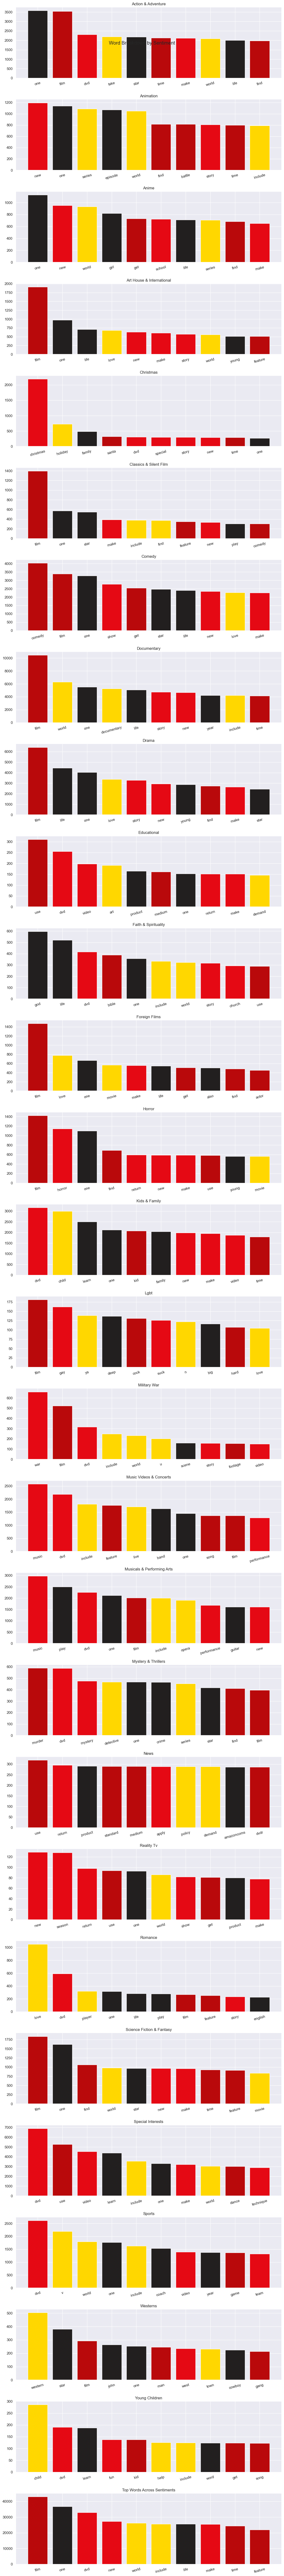

In [14]:
freq_words = word_plot(content_based, 'genre', 'description',
    n_words=10, theme=flix_colors)

In [17]:
sw = [
    'amazoncom', 'amazoncoms', 'dvdr', 'dvd', 'vcr','dvr',
    'vhs', 'demand', 'use', 'film', 'video', 'young', 'feature'
]

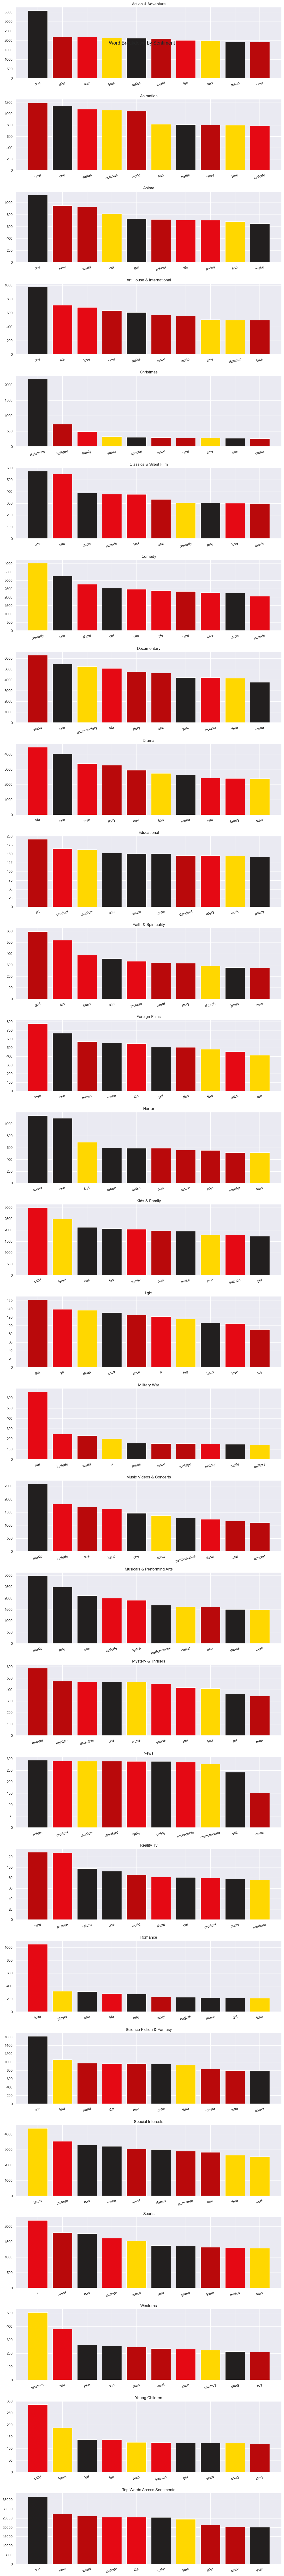

In [18]:
content_based['description'] = content_based['description'].apply(tokenize_sw)
freq_words = word_plot(content_based, 'genre', 'description',
    n_words=10, theme=flix_colors)

In [19]:
more_words = [
    'year', 'story', 'feature', 'time'
    ]
sw.extend(more_words)

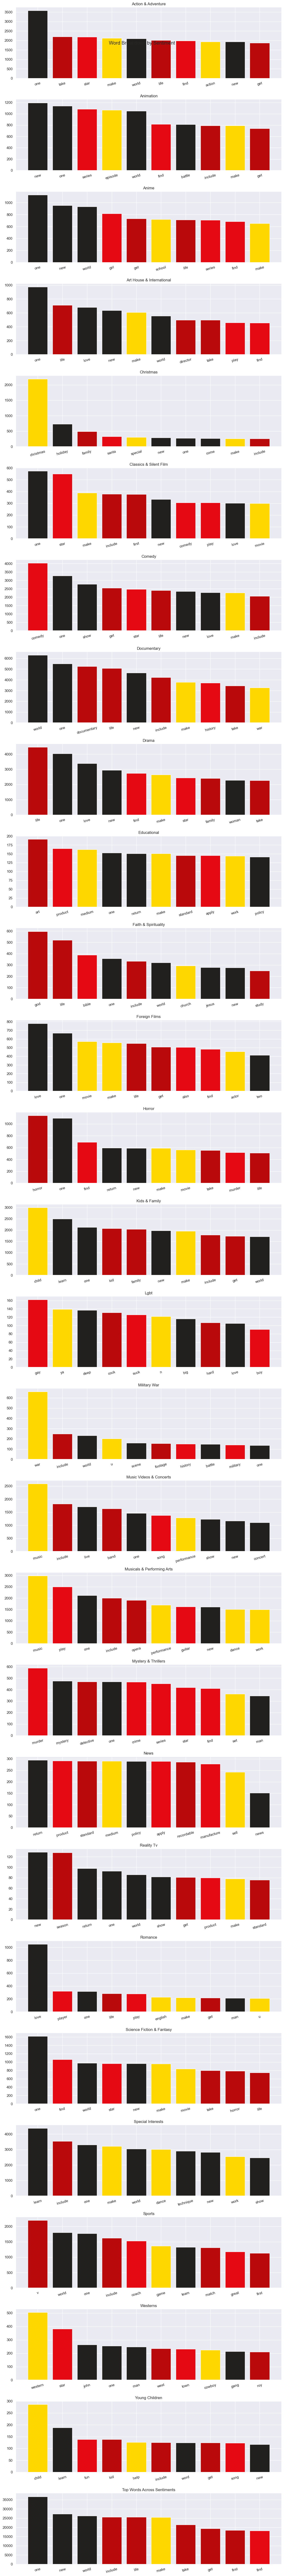

In [20]:
content_based['description'] = content_based['description'].apply(tokenize_sw)
freq_words = word_plot(content_based, 'genre', 'description',
    n_words=10, theme=flix_colors)

In [22]:
last_words = [
    'set','play','take', 'one', 'two', 'watch',
    'best','manufacture', 'season', 'recordable',
    'new', 'release'
    ]
sw.extend(last_words)

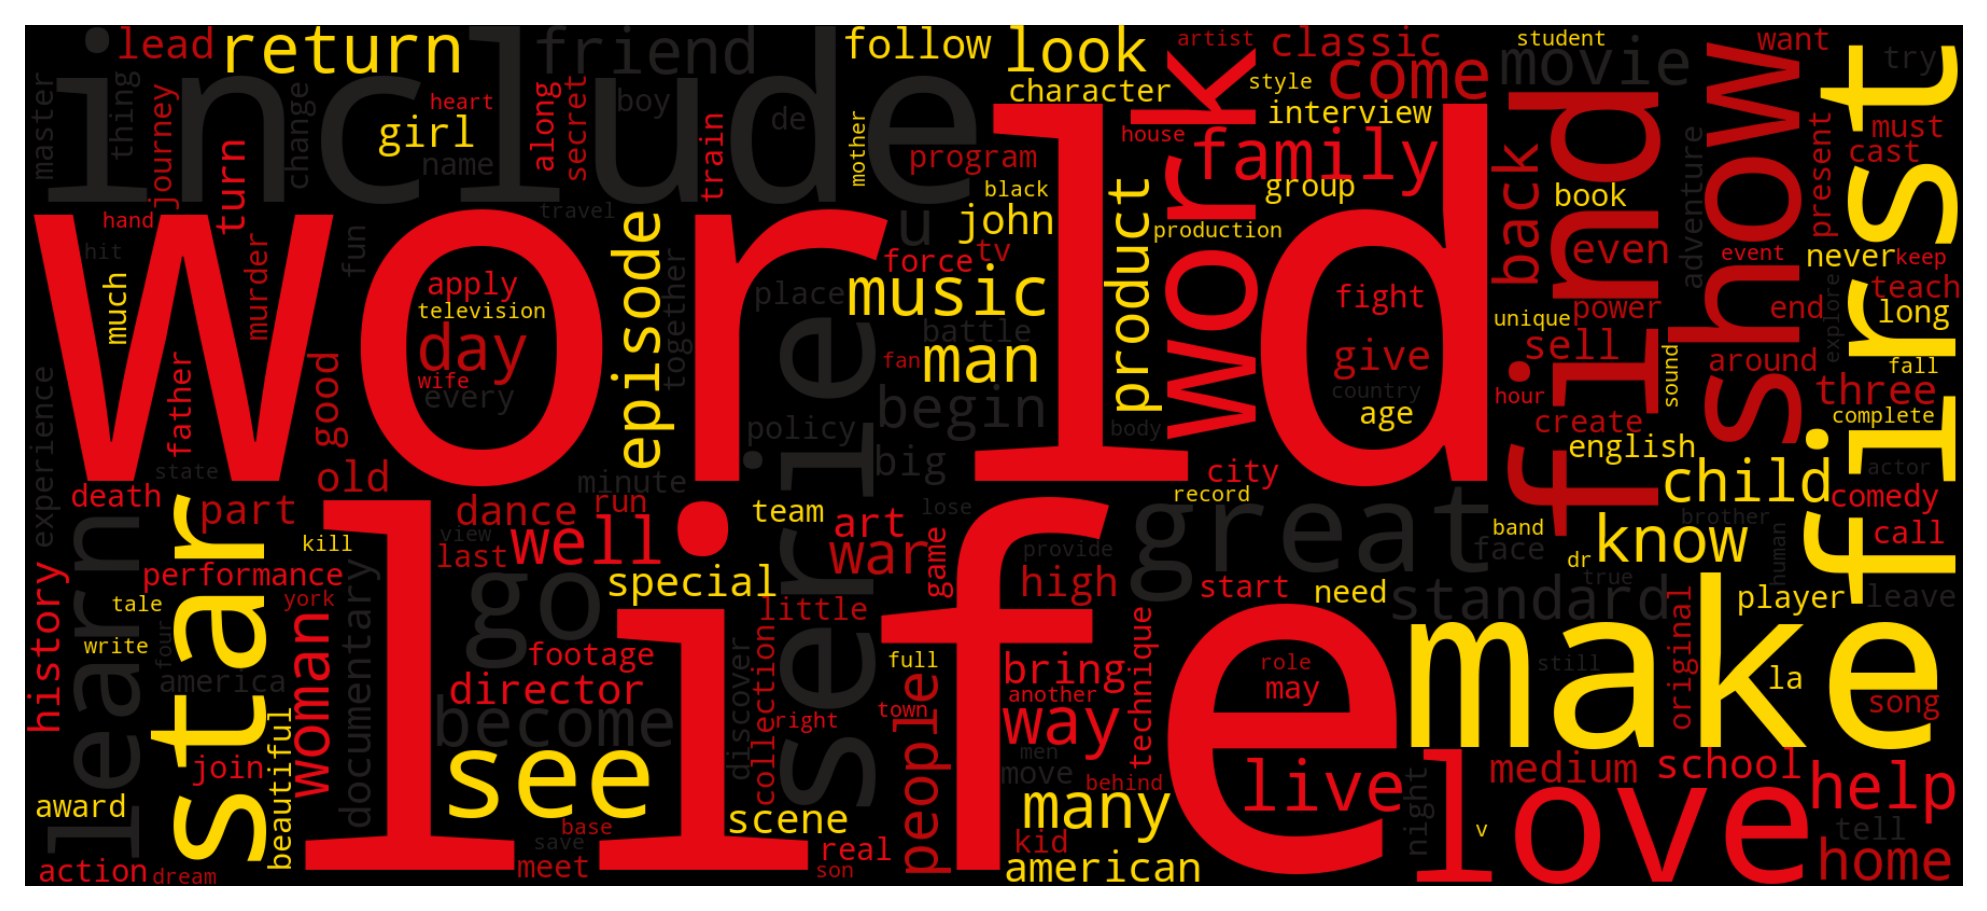

In [23]:
content_based['description'] = content_based['description'].apply(tokenize_sw)
wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='black'
).generate(' '.join(content_based['description']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Analyzing preprocessing of description features:
With more time I'd like to further process the features found in descriptions. Thought there seems to be specific language that is unique to certain video genres there is still a lot of words that at seem to be general language used in all movie descriptions. With more time I'd like to be more specific about the words kept for the vectorized dataset.

Also, I'd like to try to classify sub-genre using NLP of descriptions or reviewtext or a combination of both instead of manual filtering (shown in data_prep_final.ipynb) to see if there would be more specific genre features that could potentially increase effectiveness of content modeling.

Finally, I'd like to analyze video content that is purely streaming video content. Currently the videos in this dataset make have a large portion that are DVD and Blu-Ray DVD and the descriptions for these videos may include language that describes the physical format that the video content is displayed on.

In [24]:
# #saved to forgo preprocessing the next time returning to this dataset
# content_based.to_csv('./data/nlp_descript_genre.csv', encoding='utf-8', index=False)

In [75]:
con_copy = pd.read_csv('./data/nlp_descript_genre.csv')
con_copy['description'] = con_copy['description'].fillna('unknown')
content_based = con_copy.copy()
content_based.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79552 entries, 0 to 79551
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        79552 non-null  object
 1   description  79552 non-null  object
 2   movie_id     79552 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


# Creating dataframe of extracted features
- Extracting the top 460 most frequent words remaining in 'description' after processing
- vectorizing the features in 'description'
- One-hot-encoding Genre to be used as features as well since I'm not confident that there is a significant difference in the feature words extracted from description that are different across all genres.

In [76]:
# instantiate vectorizer and extract top 460 features from 'description'
vectorizer = TfidfVectorizer(max_features=460)
tf_genre = vectorizer.fit_transform(content_based['description'])
tf_genre = pd.DataFrame(tf_genre.todense(), columns=vectorizer.get_feature_names_out(), index=content_based.index)

# One-hot-encode 'genre' column
genre_dummied = pd.get_dummies(content_based['genre'], prefix='genre')

# Concatenate DataFrames to combine features and remove used 'description' and 'genre' columns
content_based = content_based.drop(['description', 'genre'], axis=1)
tf_genre = pd.concat([content_based, genre_dummied, tf_genre], axis=1)
tf_genre.set_index('movie_id', inplace=True)
tf_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79552 entries, 0001421409 to B01HJCCLOY
Columns: 487 entries, genre_Action & Adventure to youll
dtypes: bool(27), float64(460)
memory usage: 281.8+ MB


In [7]:
vectorizer = TfidfVectorizer(max_features=460)
tf_genre = vectorizer.fit_transform(content_based['description'])
tf_genre = pd.DataFrame(tf_genre.todense(), columns=vectorizer.get_feature_names_out(), index=content_based.index)

tf_genre = pd.concat([content_based.drop(['description'], axis=1), tf_genre], axis=1)
tf_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80231 entries, 0001421409 to B01HJCCLOY
Columns: 487 entries, genre_Action & Adventure to youll
dtypes: float64(460), int32(27)
memory usage: 290.4+ MB


### Similarity Algorithm Functions:

**cos_recs_genre()**: Calculates similarity scores between movies using cosine_similarity() from sklearn, leveraging TF-IDF features.

**knn_recs_genre()**: Employs NearestNeighbors model from sklearn with 'cosine' metric, conducting k-nearest neighbors search based on cosine similarity.

Both return the top 5 recommendations for a movie. The first calculates the cosine similarity matrix directly, while the second utilizes a k-nearest neighbors model.

In [77]:
def cos_recs_genre(vectorized_df, movie_df, movie_id=None):
    
    # If no movie_id is given, randomly pick a movie_id from the available movie_ids
    if movie_id is None:
        movie_id = random.choice(movie_df['movie_id'])
    
    # Get the input movie's information (title, genre, and starring) from movie_df
    input_movie_info = movie_df.loc[movie_df.movie_id == movie_id, ['title', 'genre', 'starring']]
    
    # Calculate the cosine similarity matrix for the vectorized_df
    cosine_matrix = cosine_similarity(vectorized_df)
    
    # Extract similarity scores for the input movie from the cosine_matrix
    similarity_scores = pd.Series(cosine_matrix[vectorized_df.index.get_loc(movie_id)], index=vectorized_df.index)
    
    # Sort the similarity scores in descending order
    sorted_scores = similarity_scores.sort_values(ascending=False)
    
    # Get the top 5 recommended movies not including the input movie
    top_recommendations = sorted_scores.loc[sorted_scores.index != movie_id].head(5)
    
    # Retrieve the recommended movies' information (title, genre, starring, and movie_id) from movie_df
    recommended_movies = movie_df.loc[movie_df.movie_id.isin(top_recommendations.index), ['title', 'genre', 'starring', 'movie_id']]
    
    # Display the input movie's information
    print("Input movie information:")
    print(input_movie_info.to_string(index=False))
    
    # Return the top 5 recommended movies
    print("\nRecommended movies:")
    return recommended_movies

In [95]:
def knn_recs_genre(vectorized_df, movie_df, movie_id=None):
    
    if movie_id is None:
        movie_id = random.choice(movie_df['movie_id'])

    # Get the input movie's information (title, genre, and starring) from movie_df
    input_movie_info = movie_df.loc[movie_df.movie_id == movie_id, ['title', 'genre', 'starring']]
    
    # The features used for the k-Nearest Neighbor model
    features = vectorized_df.values
    
    # Initialize the k-Nearest Neighbor model with 6 neighbors and cosine distance metric
    model = NearestNeighbors(n_neighbors=6, metric='cosine')
    # Fit the model with the features (vectorized_df values)
    model.fit(features)
    
    # Find the distances and indices of the 6 nearest neighbors for the input movie's features
    distances, indices = model.kneighbors(vectorized_df.loc[movie_id].values.reshape(1, -1), return_distance=True)
    
    # Get the top 5 recommended movies from the indices, excluding the input movie
    top_recommendations = [vectorized_df.index[i] for i in indices[0][1:]]
    
    # Retrieve the recommended movies' information (title, genre, starring, and movie_id) from movie_df
    recommended_movies = movie_df.loc[movie_df.movie_id.isin(top_recommendations), ['title', 'genre', 'starring', 'movie_id']]
    
    # Display the input movie's information
    print("Input movie information:")
    print(input_movie_info.to_string(index=False))
    
    # Return the top 5 recommended movies
    print("\nRecommended movies:")
    return recommended_movies

In [62]:
cosine_recommendations_genre = cos_recs_genre(tf_genre, movie_df, movie_id='B000BYA4JW')
cosine_recommendations_genre

Input movie information:
                                title  genre   starring
The Fresh Prince of Bel-Air: Season 3 Comedy Will Smith

Recommended movies:


title   genre   
31176       The Fresh Prince of Bel-Air: Season 4  Comedy  \
47213                     Agitbrigada "Bey Vraga"  Comedy   
47571  Ukrowenie stroptivogo /Il Bisbetico Domato  Comedy   
60618                 Ranczo Sezon 4 (Pal System)  Comedy   
89054                         Devushka bez adresa  Comedy   

                                                starring    movie_id  
31176                                      William Smith  B000FL7C8W  
47213                                  Vitalij Mel'nikov  B00169MIOK  
47571                                    Giuseppe Moccia  B00171EQVK  
60618                                    Various Artists  B002V7RYL8  
89054  Nikolaj Rybnikov, Yurij Belov, Sergej Filippov...  B00NCEL8JS

In [96]:
knn_recommendations_genre = knn_recs_genre(tf_genre, movie_df, movie_id='B000BYA4JW')
knn_recommendations_genre

Input movie information:
                                title  genre   starring
The Fresh Prince of Bel-Air: Season 3 Comedy Will Smith

Recommended movies:


title   genre   
31176       The Fresh Prince of Bel-Air: Season 4  Comedy  \
47213                     Agitbrigada "Bey Vraga"  Comedy   
47571  Ukrowenie stroptivogo /Il Bisbetico Domato  Comedy   
89054                         Devushka bez adresa  Comedy   
89975    Lyudi i manekeny (Russian Language Only)  Comedy   

                                                starring    movie_id  
31176                                      William Smith  B000FL7C8W  
47213                                  Vitalij Mel'nikov  B00169MIOK  
47571                                    Giuseppe Moccia  B00171EQVK  
89054  Nikolaj Rybnikov, Yurij Belov, Sergej Filippov...  B00NCEL8JS  
89975                                     Arkadiy Raykin  B00PHU0QTI

In [65]:
cosine_recommendations_genre = cos_recs_genre(tf_genre, movie_df, movie_id='B001XW7ICW')
cosine_recommendations_genre

Input movie information:
        title              genre     starring
The Middleman Action & Adventure Matt Keeslar

Recommended movies:


title               genre   
32640                    Alias - The Complete Collection  Action & Adventure  \
84343                      Ranczo Sezon 7 (4-dvd , PAL )  Action & Adventure   
85701  Czas Honoru Season 6, Polish TV miniseries, Re...  Action & Adventure   
86784                     Czas Honoru Sezon 1-6 (24 DVD)  Action & Adventure   
89076      Moy drug Ivan Lapshin (Russian Language Only)  Action & Adventure   

                                                starring    movie_id  
32640                                    Jennifer Garner  B000H5V8DG  
84343  Krlikowski Pawel, ak Cezary, Slawomir Orzechow...  B00GNOIRHU  
85701  Wieczorkowski Jan, Wesolowski Jakub, Bold Olga...  B00I9QF0AC  
86784  Jakub Wesolowski, Antoni Pawlicki, Maciej Zako...  B00JLPPKQO  
89076  Andrey Mironov, Valentin Nikulin, Nina Ruslano...  B00NF0DVMG

In [92]:
knn_recommendations_genre = knn_recs_genre(tf_genre, movie_df, movie_id='B001XW7ICW')
knn_recommendations_genre

Input movie information:
        title              genre     starring
The Middleman Action & Adventure Matt Keeslar

Recommended movies:


title               genre   
32640                    Alias - The Complete Collection  Action & Adventure  \
84343                      Ranczo Sezon 7 (4-dvd , PAL )  Action & Adventure   
85701  Czas Honoru Season 6, Polish TV miniseries, Re...  Action & Adventure   
86784                     Czas Honoru Sezon 1-6 (24 DVD)  Action & Adventure   
89076      Moy drug Ivan Lapshin (Russian Language Only)  Action & Adventure   

                                                starring    movie_id  
32640                                    Jennifer Garner  B000H5V8DG  
84343  Krlikowski Pawel, ak Cezary, Slawomir Orzechow...  B00GNOIRHU  
85701  Wieczorkowski Jan, Wesolowski Jakub, Bold Olga...  B00I9QF0AC  
86784  Jakub Wesolowski, Antoni Pawlicki, Maciej Zako...  B00JLPPKQO  
89076  Andrey Mironov, Valentin Nikulin, Nina Ruslano...  B00NF0DVMG

In [66]:
cosine_recommendations_genre = cos_recs_genre(tf_genre, movie_df, movie_id= 'B000BOH9AY')
cosine_recommendations_genre

Input movie information:
             title genre        starring
Invader Zim 3 Pack Anime Various Artists

Recommended movies:


title  genre              starring   
12303  Mobile Suit Gundam Wing - Operation 10  Anime         Mark Hildreth  \
28506         Stratos 4 - Complete Collection  Anime           Yumi Kakazu   
30834             X TV Re-Mix Collector's Set  Anime       Various Artists   
54976                         Fehérlófia 1982  Anime       Various Artists   
93570         Dragon Ball Z: Resurrection 'F'  Anime  Christopher R. Sabat   

         movie_id  
12303  B00005NB8S  
28506  B000CQQIAI  
30834  B000FFJ8S0  
54976  B001P82XPG  
93570  B014604U5K

In [93]:
knn_recommendations_genre = knn_recs_genre(tf_genre, movie_df, movie_id ='B000BOH9AY')
knn_recommendations_genre

Input movie information:
             title genre        starring
Invader Zim 3 Pack Anime Various Artists

Recommended movies:


title  genre              starring   
12303  Mobile Suit Gundam Wing - Operation 10  Anime         Mark Hildreth  \
28506         Stratos 4 - Complete Collection  Anime           Yumi Kakazu   
30834             X TV Re-Mix Collector's Set  Anime       Various Artists   
54976                         Fehérlófia 1982  Anime       Various Artists   
93570         Dragon Ball Z: Resurrection 'F'  Anime  Christopher R. Sabat   

         movie_id  
12303  B00005NB8S  
28506  B000CQQIAI  
30834  B000FFJ8S0  
54976  B001P82XPG  
93570  B014604U5K

In [78]:
cosine_recommendations_genre = cos_recs_genre(tf_genre, movie_df, movie_id= 'B004W75BQU')
cosine_recommendations_genre

Input movie information:
                    title genre             starring
One Piece: Collection One Anime Colleen Clinkenbeard

Recommended movies:


title  genre              starring   
63211     Dragon Ball Z: Dragon Box Four  Anime     Stephanie Nadolny  \
64216         Kaleido Star: Season 2 OVA  Anime           Jay Hickman   
64219      Dragon Ball Z Kai: Part Three  Anime  Christopher R. Sabat   
64797     Dragon Ball Z: Dragon Box Five  Anime     Stephanie Nadolny   
65491  One Piece: Season 3, Fifth Voyage  Anime  Colleen Clinkenbeard   

         movie_id  
63211  B003SPDS80  
64216  B0043988K8  
64219  B0043988HG  
64797  B0049TC8IK  
65491  B004DMIIV4

In [94]:
knn_recommendations_genre = knn_recs_genre(tf_genre, movie_df, movie_id ='B004W75BQU')
knn_recommendations_genre

Input movie information:
                    title genre             starring
One Piece: Collection One Anime Colleen Clinkenbeard

Recommended movies:


title  genre              starring   
63211     Dragon Ball Z: Dragon Box Four  Anime     Stephanie Nadolny  \
64216         Kaleido Star: Season 2 OVA  Anime           Jay Hickman   
64219      Dragon Ball Z Kai: Part Three  Anime  Christopher R. Sabat   
64797     Dragon Ball Z: Dragon Box Five  Anime     Stephanie Nadolny   
65491  One Piece: Season 3, Fifth Voyage  Anime  Colleen Clinkenbeard   

         movie_id  
63211  B003SPDS80  
64216  B0043988K8  
64219  B0043988HG  
64797  B0049TC8IK  
65491  B004DMIIV4

### Overall Similarity Function Evaluations:
For both similarity functions the content based recommendations appear to perform well recommending content of the same exact genre.

However, it leans towards movies of the same genre, working well in this dataset for more specific genres like 'Anime' and 'Faith & Spirituality', but offering dissimilar recommendations for broader genres in the dataset like 'Comedy'. 

Because most of the genres in this dataset are broad and do not capture the minute differences found in more specific sub-genre like 'Christmas' the content being recommended is only relatively similar and not creating very relavant recommendations.

# Conclusions
After the evaluation and analysis of the content-based filtering system for recommending similar movies, it was suggested to preprocess the description features for better specificity of the vectorized dataset. To increase the effectiveness of content modeling, NLP could be utilized for sub-genre classification instead of manual filtering. Analyzing purely streaming video content could also provide more insight for the system. The system performed well in recommending content of the same genre, but it lacked accuracy in capturing minute differences in specific sub-genres. Thus, resulting in less relevant recommendations for broader genres in the dataset. Exploring ways to improve the specificity and accuracy of the system is recommended for better recommendations.